In [83]:
import os
from typing import List, Any
import numpy as np
import pandas as pd
import inspect
os.listdir("./docs/results/distributed")

['accuracy_centralized_balanced_C=10_B=32_E=5_R=2_mu=0.0_strag=0.0_O=sgd.png',
 'centralized_metrics.png',
 'centralized_metrics_0.png',
 'centralized_metrics_06.png',
 'centralized_metrics_06_fedmed.png',
 'hist_balanced_C=10_B=32_E=5_R=2_mu=0.0_strag=0.0_O=sgd.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=adagrad.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=adagrad_strat=fedmedian.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=adam.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=sgd.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=sgd_strat=fedmedian.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=yogi.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.0_CO=sgd_SO=yogi_strat=fedmedian.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.6_CO=sgd_SO=adagrad.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.6_CO=sgd_SO=adagrad_strat=fedmedian.npy',
 'hist_C=10_B=32_E=5_R=200_mu=0.0_strag=0.6_CO=sgd_SO=adam.npy',
 'hist_

In [166]:
MUS = [0.0, 1.0]
CLASSES = 10
B = 32
E = 5
R = 200
STRAGGLERS = [.0, .6]
CLIENT_OPTIMIZER = "sgd"
SERVER_OPTIMIZERS = ["sgd", "adagrad", "adam", "yogi"]
STRATS = ["fedmedian", "fedprox"]
BASE_PATH = "./docs/results/distributed/hist_C={0}_B={1}_E={2}_R={3}_mu={4}_strag={5}_CO={6}_SO={7}{8}.npy"


class Experiment():
    def __init__(self, 
                 **kwargs) -> None:
        
        self.props = kwargs

        strat_req = "_strat=fedmedian" if self.props["strat"] == "fedmedian" else ""

        self.path = BASE_PATH.format(self.props["classes"],
                                     self.props["b"],
                                     self.props["epochs"],
                                     self.props["r"],
                                     self.props["mu"],
                                     self.props["stragg"],
                                     self.props["client_opt"],
                                     self.props["server_opt"],
                                     strat_req)

        

    def load_res(self) -> bool:
        if(self.path.split("/")[-1] in os.listdir("./docs/results/distributed")):
            self.res = pd.DataFrame(np.load(self.path, allow_pickle=True).item().metrics_centralized["accuracy"])
            self.res.columns = ["round", "accuracy"]
            for prop_k, prop_v in self.props.items():
                self.res[prop_k] = prop_v
            return True
        return False
    
    def get_res(self) -> np.array :
        if(self.res is None):
            raise ValueError("Result not loaded yet")
        return self.res

    def __str__(self) -> str:
        return ", ".join([str(k) + "=" + str(v)  for k, v in self.props.items()])

In [167]:
experiments = []
for strat in STRATS:
    for so in SERVER_OPTIMIZERS:
        for strag in STRAGGLERS:
            for mu in MUS:
                exp = Experiment(mu=mu,
                        classes=CLASSES,
                        b=B,
                        r=R,
                        epochs=E,
                        stragg=strag,
                        client_opt=CLIENT_OPTIMIZER,
                        server_opt=so,
                        strat=strat)
                if(exp.load_res()):
                    experiments.append(exp)

In [96]:
fdf = pd.concat([exp.get_res() for exp in experiments])

In [107]:
fdf.head()

,round,accuracy,mu,classes,b,r,epochs,stragg,client_opt,server_opt,strat
0,0,0.0516,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian
1,1,0.6156,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian
2,2,0.6748,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian
3,3,0.8389,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian
4,4,0.8672,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian


In [100]:
import seaborn as sns
from matplotlib import pyplot as plt

In [215]:
def plot_on_(cols, for_=fdf):
    def format_entry(entry):
        f_val = ""
        for k, v in entry.items():
            f_val += str(k) + "=" + str(v) + ", "
        return f_val 
    f = plt.figure(figsize=(12, 7))
    temp = for_.copy()
    temp["hue"] = temp[cols].apply(format_entry, axis=1)
    g = sns.lineplot(data=temp, x="round", y="accuracy", hue="hue")
    g.set_ylim((0.8, 1))
    del temp
    return g

#### Stragglers

There is no particular impact of stragglers overall

<Axes: xlabel='round', ylabel='accuracy'>

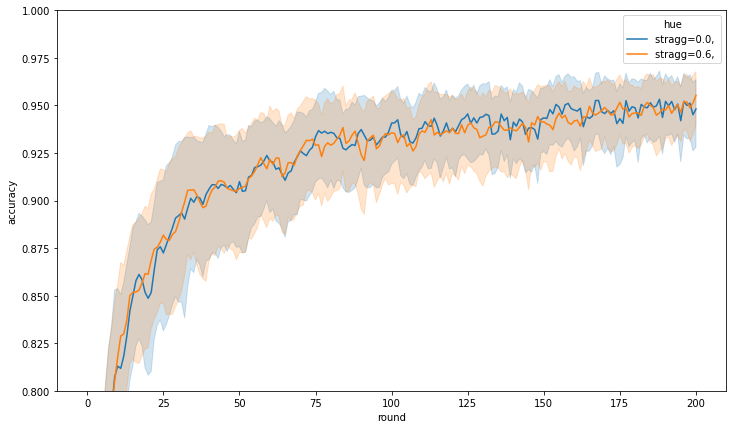

In [216]:
plot_on_(["stragg"])

### Server Optimizer

Let's see the overall impaoct of server optimizer

<Axes: xlabel='round', ylabel='accuracy'>

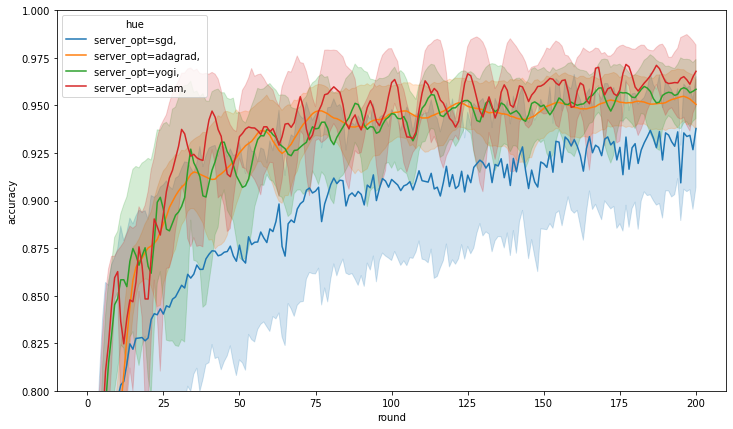

In [217]:
plot_on_(["server_opt"])

#### Overall impact of the aggregation strategy

<Axes: xlabel='round', ylabel='accuracy'>

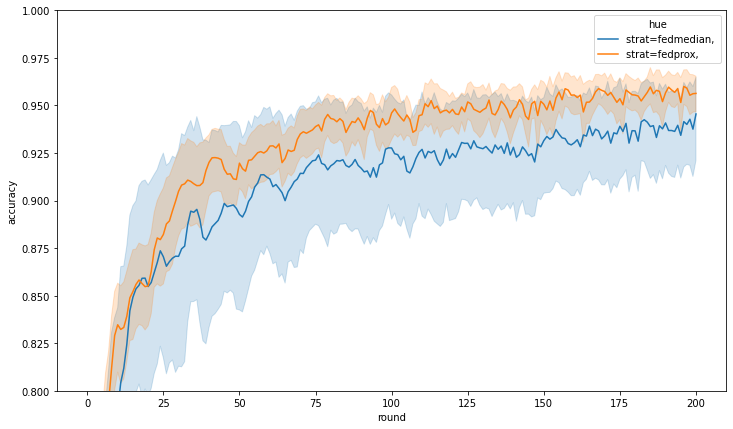

In [218]:
plot_on_(["strat"])

## Combination of variables :

<Axes: xlabel='round', ylabel='accuracy'>

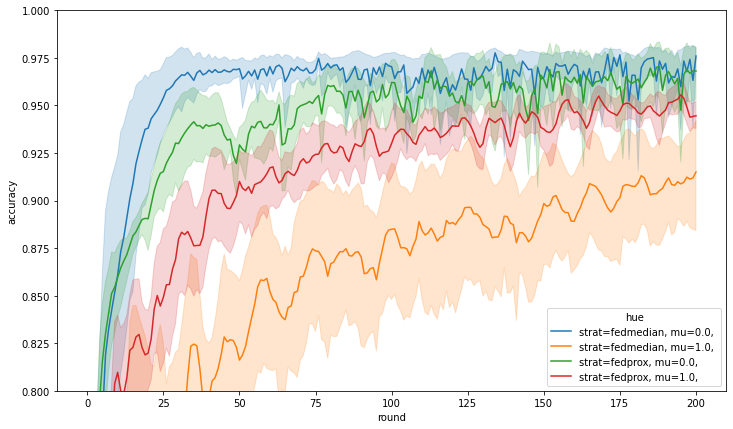

In [219]:
plot_on_(["strat", "mu"])

<Axes: xlabel='round', ylabel='accuracy'>

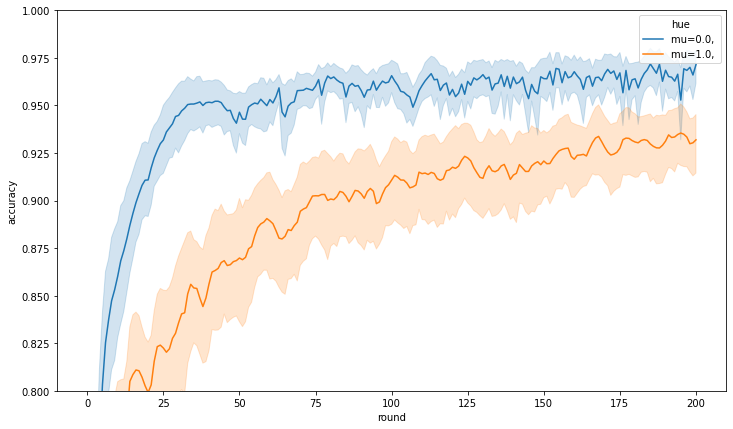

In [282]:
plot_on_(["mu"])

Which aggregation strategy and server optimizer performs better on a setup with $60\%$ stragglers setup

<Axes: xlabel='round', ylabel='accuracy'>

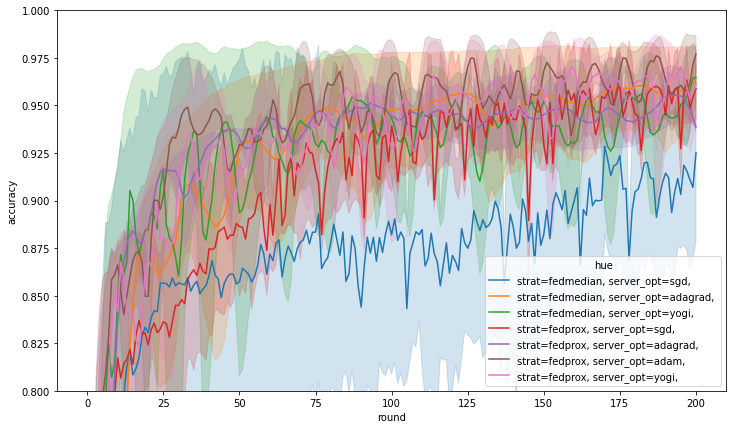

In [220]:
plot_on_(["strat", "server_opt"], for_=fdf[fdf.stragg == .6])

Setup with FedProx with $\mu = 1$, $60\%$ stragglers, let's see with server optimizer performs best

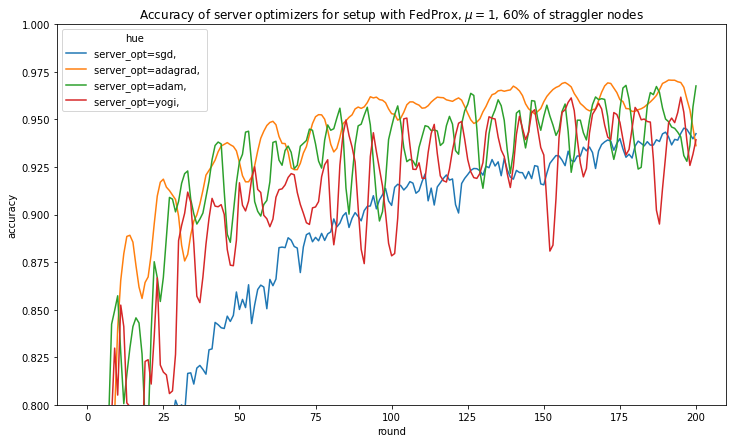

In [221]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.mu == 1.0) & (fdf.stragg == 0.6) & (fdf.strat == "fedprox")])
g.set_title("Accuracy of server optimizers for setup with FedProx, $\mu = 1$, $60\%$ of straggler nodes");

Setup with FedProx with $\mu = 1$, without stragglers, let's see with server optimizer performs best

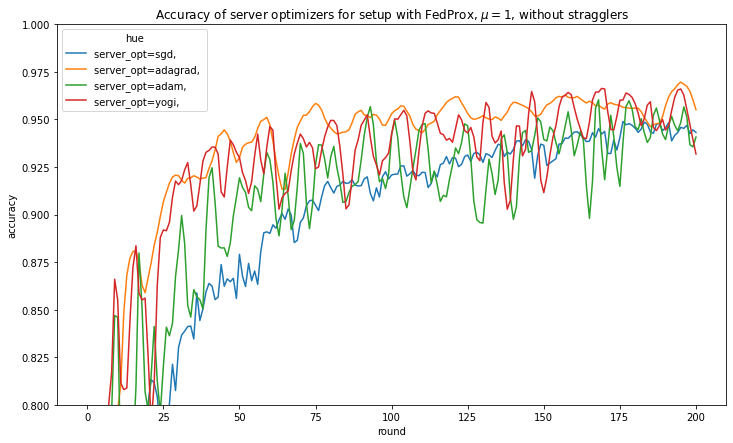

In [222]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.mu == 1.0) & (fdf.stragg == 0.0) & (fdf.strat == "fedprox")])
g.set_title("Accuracy of server optimizers for setup with FedProx, $\mu = 1$, without stragglers");

Setup with FedMedian with $\mu = 1$, $60\%$ stragglers, let's see with server optimizer performs best

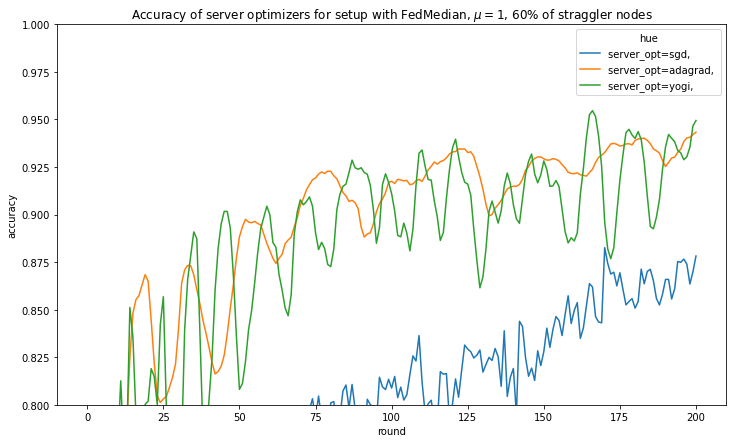

In [223]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.mu == 1.0) & (fdf.stragg == 0.6) & (fdf.strat == "fedmedian")])
g.set_title("Accuracy of server optimizers for setup with FedMedian, $\mu = 1$, $60\%$ of straggler nodes");

Setup with FedMedian with $\mu = 1$, without stragglers, let's see with server optimizer performs best

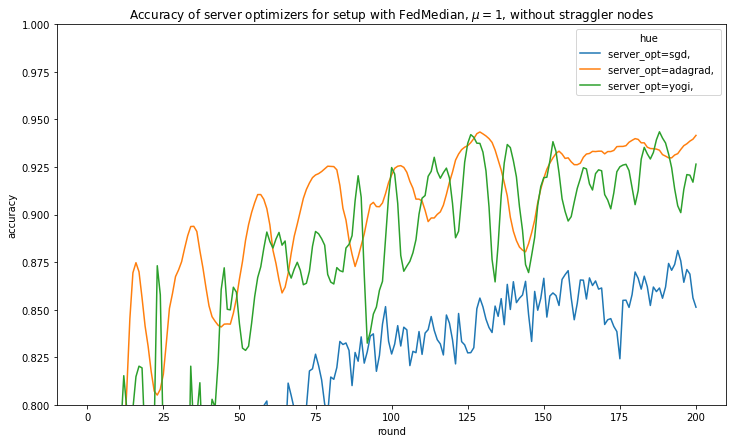

In [224]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.mu == 1.0) & (fdf.stragg == 0.0) & (fdf.strat == "fedmedian")])
g.set_title("Accuracy of server optimizers for setup with FedMedian, $\mu = 1$, without straggler nodes");

We want to check which combination of server optimizer and (mu, strat) works best **if no stragglers are involved** 

Text(0.5, 1.0, 'Accuracy for setup with $60\\%$ straggelers involved')

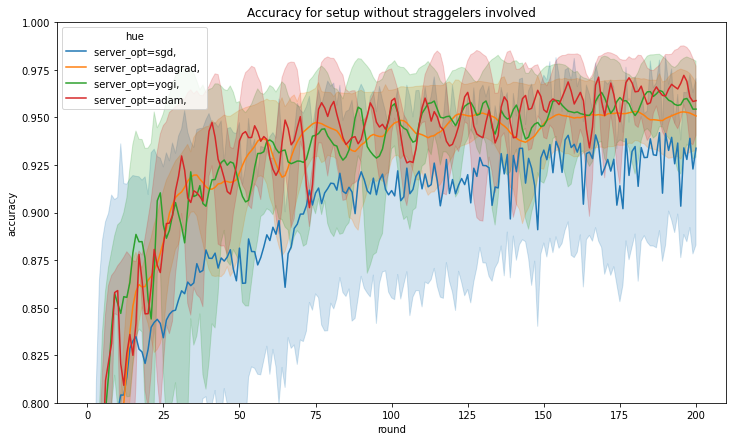

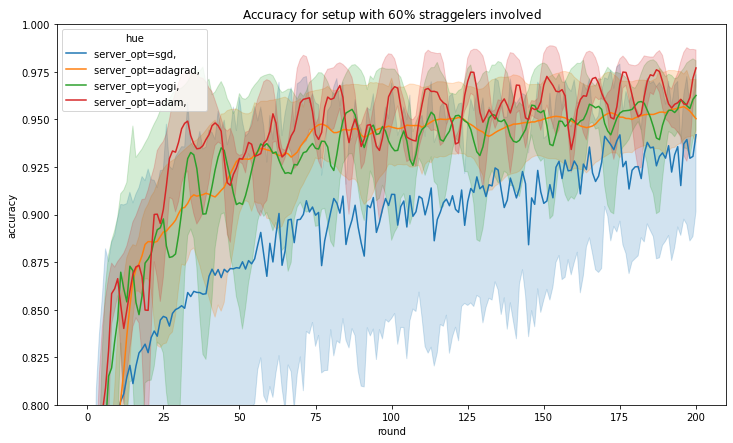

In [225]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.0)])
g.set_title("Accuracy for setup without straggelers involved")

g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == .6)])
g.set_title("Accuracy for setup with $60\%$ straggelers involved")

## Experiments 

We want to determine which on is the best optimizer in different setup


### 1) On stragglers network 

##### A - with FedAverage

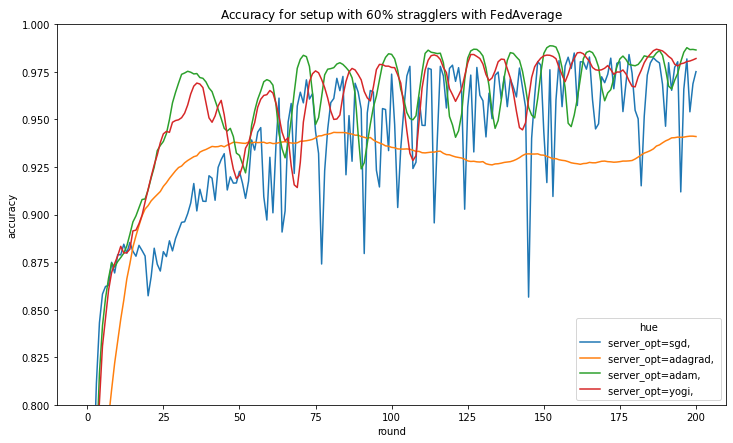

In [226]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.6) & (fdf.strat == "fedprox") & (fdf.mu == 0.0)])
g.set_title("Accuracy for setup with $60\%$ stragglers with FedAverage");

##### B - with FedMedian

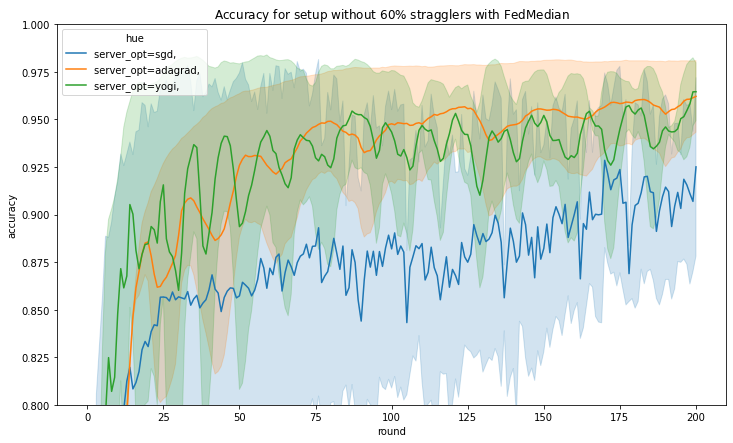

In [227]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.6) & (fdf.strat == "fedmedian")])
g.set_title("Accuracy for setup without $60\%$ stragglers with FedMedian");

##### C - with FedProx

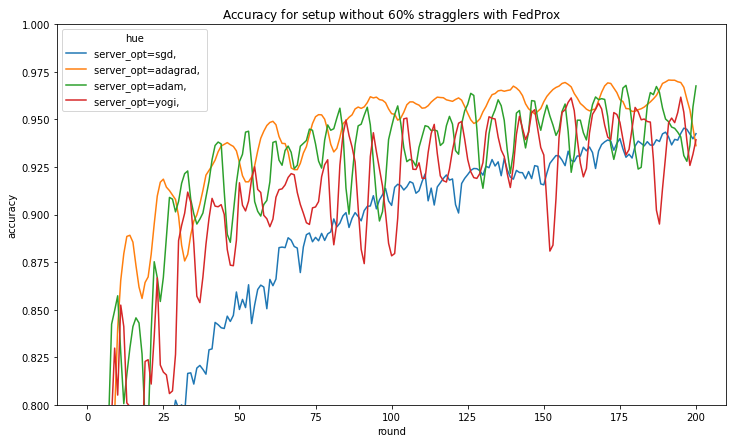

In [228]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.6) & (fdf.strat == "fedprox") & (fdf.mu == 1.0)])
g.set_title("Accuracy for setup without $60\%$ stragglers with FedProx");

### 2) On non-straggler network 

##### A - with FedAverage

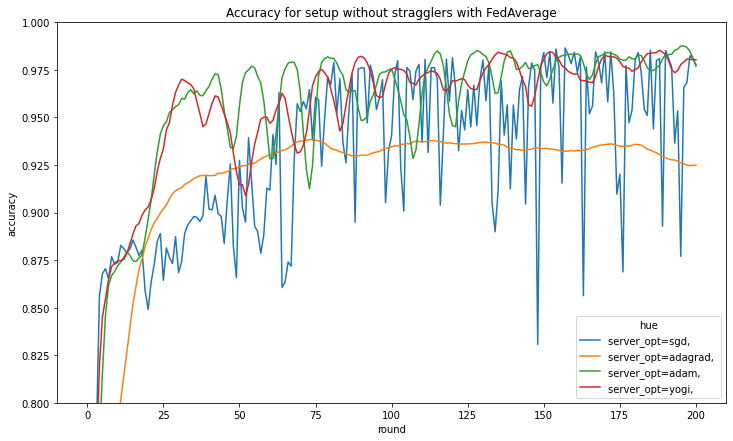

In [229]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.0) & (fdf.strat == "fedprox") & (fdf.mu == 0.0)])
g.set_title("Accuracy for setup without stragglers with FedAverage");

##### B - with FedMedian

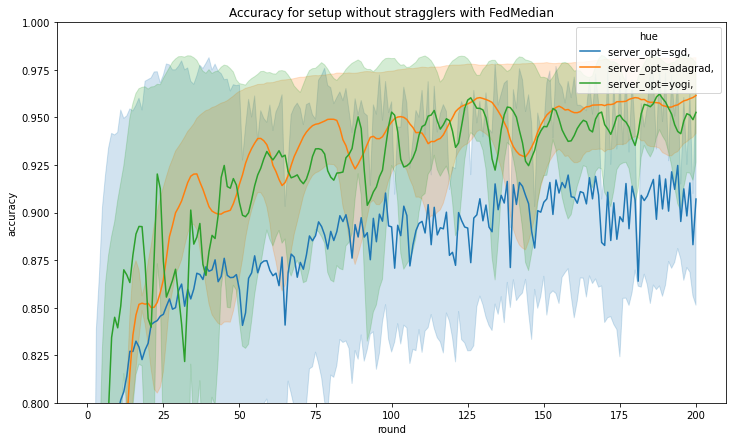

In [230]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.0) & (fdf.strat == "fedmedian")])
g.set_title("Accuracy for setup without stragglers with FedMedian");

##### C - with FedProx

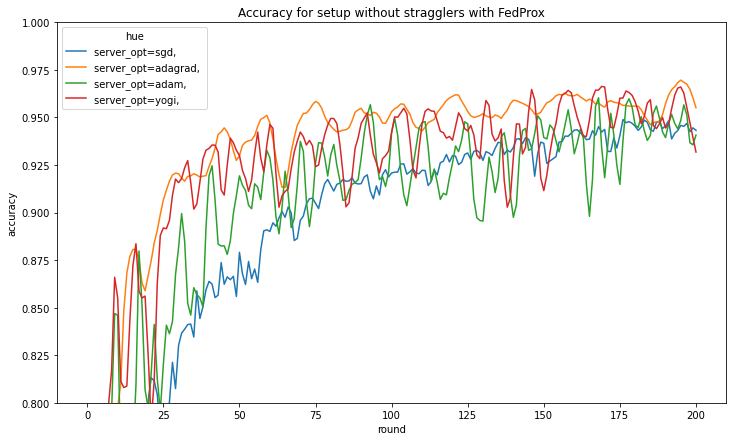

In [231]:
g = plot_on_(["server_opt"], for_=fdf[(fdf.stragg == 0.0) & (fdf.strat == "fedprox") & (fdf.mu == 1.0)])
g.set_title("Accuracy for setup without stragglers with FedProx");

### Metrics :

- Number of rounds to get to $95\%$ accuracy
- Final acurracy
- Std deviation of the accuracy curve

In [270]:
experiment_keys = list(experiments[0].props.keys())

def agg_metrics(subdf):
    agg = subdf[experiment_keys].drop_duplicates()
    if(len(subdf[subdf.accuracy >= 0.95].index.values) > 0):
        agg["min_95_index"] = subdf[subdf.accuracy >= 0.95].index.values[0]
    else :
        agg["min_95_index"] = float("inf")
    agg["max_accuracy"] = subdf["accuracy"].max()
    agg["final_accuracy"] = subdf["accuracy"].values[-1]
    agg["std_accuracy"] = subdf["accuracy"].std()
    return agg

    
metrics = fdf.groupby(experiment_keys, group_keys=False).apply(agg_metrics)
metrics

,mu,classes,b,r,epochs,stragg,client_opt,server_opt,strat,min_95_index,max_accuracy,final_accuracy,std_accuracy
0,0.0,10,32,200,5,0.0,sgd,adagrad,fedmedian,37.0,0.9814,0.9814,0.109612
0,0.0,10,32,200,5,0.0,sgd,adagrad,fedprox,inf,0.9383,0.9249,0.084021
0,0.0,10,32,200,5,0.0,sgd,adam,fedprox,27.0,0.9876,0.9769,0.071208
0,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian,11.0,0.9814,0.9629,0.073694
0,0.0,10,32,200,5,0.0,sgd,sgd,fedprox,63.0,0.9865,0.9778,0.077596
0,0.0,10,32,200,5,0.0,sgd,yogi,fedmedian,15.0,0.9831,0.9788,0.085911
0,0.0,10,32,200,5,0.0,sgd,yogi,fedprox,28.0,0.9853,0.9803,0.076341
0,0.0,10,32,200,5,0.6,sgd,adagrad,fedmedian,38.0,0.9813,0.9809,0.103794
0,0.0,10,32,200,5,0.6,sgd,adagrad,fedprox,inf,0.9432,0.9410,0.075937
0,0.0,10,32,200,5,0.6,sgd,adam,fedprox,28.0,0.9887,0.9865,0.077503


### Ranking for the metric : minimum round to reach 95\%

In [271]:
metrics.sort_values("min_95_index", ascending=True)

,mu,classes,b,r,epochs,stragg,client_opt,server_opt,strat,min_95_index,max_accuracy,final_accuracy,std_accuracy
0,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian,11.0,0.9814,0.9629,0.073694
0,0.0,10,32,200,5,0.6,sgd,yogi,fedmedian,13.0,0.9839,0.9797,0.082117
0,0.0,10,32,200,5,0.0,sgd,yogi,fedmedian,15.0,0.9831,0.9788,0.085911
0,0.0,10,32,200,5,0.6,sgd,sgd,fedmedian,18.0,0.9815,0.9719,0.071570
0,0.0,10,32,200,5,0.0,sgd,adam,fedprox,27.0,0.9876,0.9769,0.071208
0,0.0,10,32,200,5,0.0,sgd,yogi,fedprox,28.0,0.9853,0.9803,0.076341
0,0.0,10,32,200,5,0.6,sgd,adam,fedprox,28.0,0.9887,0.9865,0.077503
0,0.0,10,32,200,5,0.6,sgd,yogi,fedprox,31.0,0.9869,0.9820,0.074747
0,0.0,10,32,200,5,0.0,sgd,adagrad,fedmedian,37.0,0.9814,0.9814,0.109612
0,0.0,10,32,200,5,0.6,sgd,adagrad,fedmedian,38.0,0.9813,0.9809,0.103794


### Ranking for the metric : Maximum accurarcy

In [272]:
metrics.sort_values("max_accuracy", ascending=False)

,mu,classes,b,r,epochs,stragg,client_opt,server_opt,strat,min_95_index,max_accuracy,final_accuracy,std_accuracy
0,0.0,10,32,200,5,0.6,sgd,adam,fedprox,28.0,0.9887,0.9865,0.077503
0,0.0,10,32,200,5,0.0,sgd,adam,fedprox,27.0,0.9876,0.9769,0.071208
0,0.0,10,32,200,5,0.6,sgd,yogi,fedprox,31.0,0.9869,0.9820,0.074747
0,0.0,10,32,200,5,0.0,sgd,sgd,fedprox,63.0,0.9865,0.9778,0.077596
0,0.0,10,32,200,5,0.0,sgd,yogi,fedprox,28.0,0.9853,0.9803,0.076341
0,0.0,10,32,200,5,0.6,sgd,sgd,fedprox,63.0,0.9849,0.9751,0.073548
0,0.0,10,32,200,5,0.6,sgd,yogi,fedmedian,13.0,0.9839,0.9797,0.082117
0,0.0,10,32,200,5,0.0,sgd,yogi,fedmedian,15.0,0.9831,0.9788,0.085911
0,0.0,10,32,200,5,0.6,sgd,sgd,fedmedian,18.0,0.9815,0.9719,0.071570
0,0.0,10,32,200,5,0.0,sgd,adagrad,fedmedian,37.0,0.9814,0.9814,0.109612


### Ranking for the metric : Final Accuracy

In [273]:
metrics.sort_values("final_accuracy", ascending=False)

,mu,classes,b,r,epochs,stragg,client_opt,server_opt,strat,min_95_index,max_accuracy,final_accuracy,std_accuracy
0,0.0,10,32,200,5,0.6,sgd,adam,fedprox,28.0,0.9887,0.9865,0.077503
0,0.0,10,32,200,5,0.6,sgd,yogi,fedprox,31.0,0.9869,0.9820,0.074747
0,0.0,10,32,200,5,0.0,sgd,adagrad,fedmedian,37.0,0.9814,0.9814,0.109612
0,0.0,10,32,200,5,0.6,sgd,adagrad,fedmedian,38.0,0.9813,0.9809,0.103794
0,0.0,10,32,200,5,0.0,sgd,yogi,fedprox,28.0,0.9853,0.9803,0.076341
0,0.0,10,32,200,5,0.6,sgd,yogi,fedmedian,13.0,0.9839,0.9797,0.082117
0,0.0,10,32,200,5,0.0,sgd,yogi,fedmedian,15.0,0.9831,0.9788,0.085911
0,0.0,10,32,200,5,0.0,sgd,sgd,fedprox,63.0,0.9865,0.9778,0.077596
0,0.0,10,32,200,5,0.0,sgd,adam,fedprox,27.0,0.9876,0.9769,0.071208
0,0.0,10,32,200,5,0.6,sgd,sgd,fedprox,63.0,0.9849,0.9751,0.073548


#### Ranking for the metric : standard deviation in accuracy

In [274]:
metrics.sort_values("std_accuracy", ascending=True)

,mu,classes,b,r,epochs,stragg,client_opt,server_opt,strat,min_95_index,max_accuracy,final_accuracy,std_accuracy
0,0.0,10,32,200,5,0.0,sgd,adam,fedprox,27.0,0.9876,0.9769,0.071208
0,0.0,10,32,200,5,0.6,sgd,sgd,fedmedian,18.0,0.9815,0.9719,0.071570
0,0.0,10,32,200,5,0.6,sgd,sgd,fedprox,63.0,0.9849,0.9751,0.073548
0,0.0,10,32,200,5,0.0,sgd,sgd,fedmedian,11.0,0.9814,0.9629,0.073694
0,0.0,10,32,200,5,0.6,sgd,yogi,fedprox,31.0,0.9869,0.9820,0.074747
0,0.0,10,32,200,5,0.6,sgd,adagrad,fedprox,inf,0.9432,0.9410,0.075937
0,0.0,10,32,200,5,0.0,sgd,yogi,fedprox,28.0,0.9853,0.9803,0.076341
0,0.0,10,32,200,5,0.6,sgd,adam,fedprox,28.0,0.9887,0.9865,0.077503
0,0.0,10,32,200,5,0.0,sgd,sgd,fedprox,63.0,0.9865,0.9778,0.077596
0,0.0,10,32,200,5,0.6,sgd,yogi,fedmedian,13.0,0.9839,0.9797,0.082117


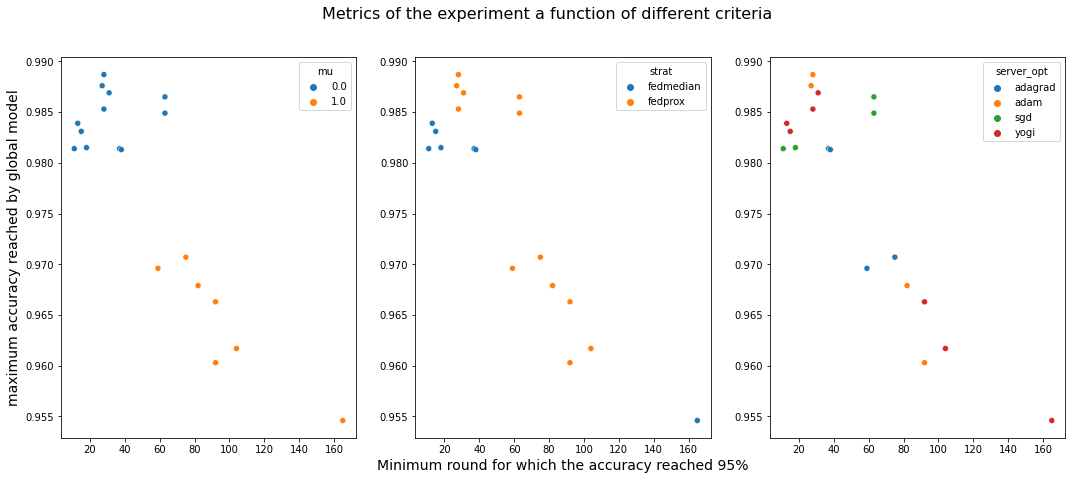

In [281]:
f, a = plt.subplots(1, 3, figsize=(18, 7))
for i, (col, ax) in enumerate(zip(["mu", "strat", "server_opt"], a.flatten())):
    g = sns.scatterplot(data=metrics, x="min_95_index", y="max_accuracy", hue=col, ax=ax)
    
    if(i != 0):
        g.set_ylabel(" ")
    else :
        g.set_ylabel("maximum accuracy reached by global model", fontsize=14)

    if(i != 1):
        g.set_xlabel(" ")
    else:
        g.set_xlabel("Minimum round for which the accuracy reached 95%", fontsize=14)

f.suptitle("Metrics of the experiment a function of different criteria", fontsize=16);

Text(0.5, 1.0, 'Fastest convergence and highest reached accuracy')

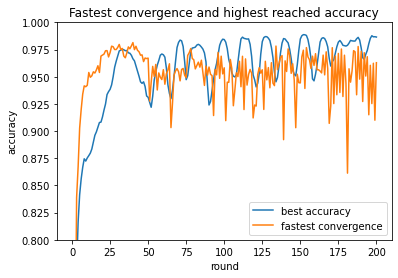

In [303]:
## best accuracy
best_accuracy = metrics.sort_values("max_accuracy", ascending=False).head(1)[experiment_keys]
sns.lineplot(data=fdf[(fdf[experiment_keys] == best_accuracy.values).sum(axis=1) == 9], y="accuracy", x="round", label="best accuracy")

## quickest convergence
quickest = metrics.sort_values("min_95_index", ascending=True).head(1)[experiment_keys]
g = sns.lineplot(data=fdf[(fdf[experiment_keys] == quickest.values).sum(axis=1) == 9], y="accuracy", x="round", label="fastest convergence")


g.set_ylim((0.80, 1))
g.set_title("Fastest convergence and highest reached accuracy")
